In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import math

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from datetime import datetime as dt
from datetime import timedelta 

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import cast, Date

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Save references to each table

Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# View columns in Measurements
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# View columns in Stations
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurements).order_by(Measurements.date.desc()).first()

print(f"Most recent date in the data set is {most_recent_date.date}")


Most recent date in the data set is 2017-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data

most_recent_date_dt_object = dt.strptime(most_recent_date.date, '%Y-%m-%d')

year_ago = dt.date(most_recent_date_dt_object) - timedelta(days=365)

stmt = session.query(Measurements.date, func.avg(Measurements.prcp)).\
    filter(Measurements.date > year_ago).\
    group_by(Measurements.date).order_by(Measurements.date).statement

average_prcp_df = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'date' : 'Date', 'avg_1': 'Ave Precip in CM'})

average_prcp_df.head()


,Date,Ave Precip in CM
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

average_prcp_df.describe()

,Ave Precip in CM
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


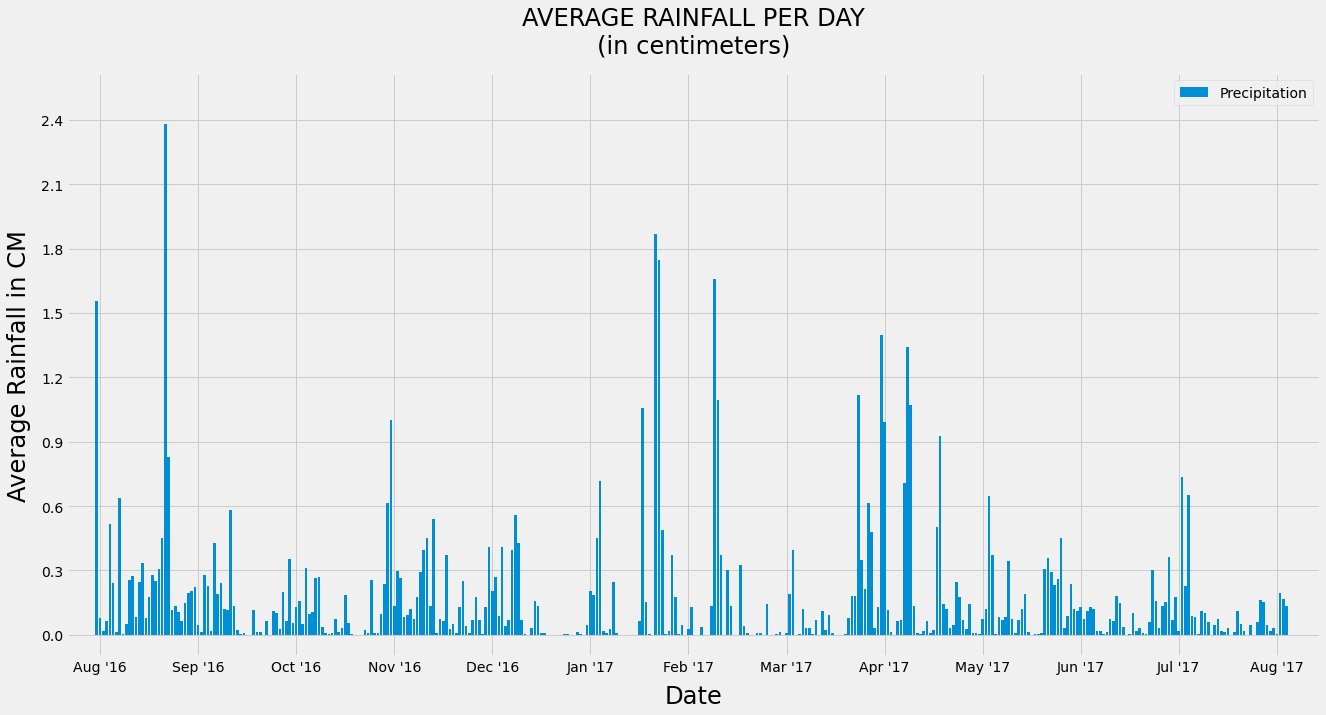

In [16]:
#Plot the average precipitation results. 

plt.figure(num=None, figsize=(20,10), dpi=None, 
                         facecolor=None, edgecolor=None, frameon=True)

x_axis = average_prcp_df['Date']

y_axis = average_prcp_df['Ave Precip in CM']
l = len(average_prcp_df)

prcp_range = max(y_axis)-min(y_axis)

x_tx = [tk_x for tk_x in range(1, (l)+1, int(l/12))]
y_tx = [round(tk_y,2) for tk_y in np.arange(0, math.ceil(prcp_range), math.ceil(prcp_range)/10)]

labels=[dt.strptime(x_axis[tk], '%Y-%m-%d').strftime("%b \'%y") for tk in x_tx]
    
plt.xticks(ticks=x_tx, labels=labels)
plt.yticks(ticks=y_tx)

plt.bar(x_axis, y_axis, label='Precipitation')

plt.xlim(-len(x_axis)*.025, len(x_axis)*1.025)
plt.ylim(-.1, max(y_axis)*1.1)

plt.title("AVERAGE RAINFALL PER DAY\n(in centimeters)", fontsize='xx-large',             # Set up title
          loc='center', pad=20)
plt.xlabel("Date", fontsize='xx-large', labelpad=10)
plt.ylabel("Average Rainfall in CM", fontsize='xx-large', labelpad=10)
plt.legend()


plt.savefig("output_charts/average_rainfall.png", transparent=False)        # Export chart

plt.show()

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(Stations.station.distinct()).count()
print(f"Total number of weather stations in the dataset: {stations_count}")

Total number of weather stations in the dataset: 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

stmt = session.query(Stations.id, Measurements.station, func.count(Measurements.station)).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).statement

most_active_stations = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'station' : 'Station Name', 'id' : 'Station ID', 'count_1': '# of Measurements'})

most_active_stations

,Station ID,Station Name,# of Measurements
0,7,USC00519281,2772
1,1,USC00519397,2724
2,2,USC00513117,2709
3,6,USC00519523,2669
4,9,USC00516128,2612
5,3,USC00514830,2202
6,8,USC00511918,1979
7,4,USC00517948,1372
8,5,USC00518838,511


In [63]:
# Using the most active station id from the previous query, calculate the 
#lowest, highest, and average temperature.

most_active_station = session.query(Stations.id, Stations.station).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).first()

min_temp, max_temp, avg_temp  = session.query(func.min(Measurements.tobs), 
                                 func.max(Measurements.tobs), 
                                 func.round(func.avg(Measurements.tobs), 1)).\
                    filter(Measurements.station == Stations.station).\
                    filter(Stations.id == most_active_station.id).all()[0]

min_max_avg_tobs_df = pd.DataFrame({'Most Active Station ID' : [most_active_station.id], 
                                    'Most Active Station Name' : [most_active_station.station],
                                    'Min Temp': min_temp,
                                    'Max Temp' : max_temp,
                                    'Avg Temp' : avg_temp})

min_max_avg_tobs_df


,Most Active Station ID,Most Active Station Name,Min Temp,Max Temp,Avg Temp
0,7,USC00519281,54.0,85.0,71.7


In [62]:
# Using the most active station id Query the last 12 months of temperature observation 
# data for this station and plot the results as a histogram

most_active_station = session.query(Stations.id, Stations.station).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).first()

most_recent_date = session.query(Measurements).\
    filter(Measurements.station == Stations.station).\
    filter(Stations.id == most_active_station.id).\
    order_by(Measurements.date.desc()).first()

most_recent_date_dt_object = dt.strptime(most_recent_date.date, '%Y-%m-%d')

one_year_before_most_recent = most_recent_date_dt_object.date() - timedelta(days=365)

stmt = session.query(Measurements.date, Measurements.tobs).\
    filter(Measurements.station == Stations.station).\
    filter(Stations.id == most_active_station.id).\
    filter(Measurements.date <= most_recent_date.date, 
           Measurements.date > one_year_before_most_recent.strftime("%Y-%m-%d")).statement 

most_active_station_12months = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'date' : 'Date', 'tobs' :f"Temp Obs at Station {most_active_station.id}"})

most_active_station_12months


,Date,Temp Obs at Station 7
0,2016-08-19,79.0
1,2016-08-20,81.0
2,2016-08-21,79.0
3,2016-08-22,78.0
4,2016-08-23,77.0
...,...,...
351,2017-08-14,77.0
352,2017-08-15,77.0
353,2017-08-16,76.0
354,2017-08-17,76.0


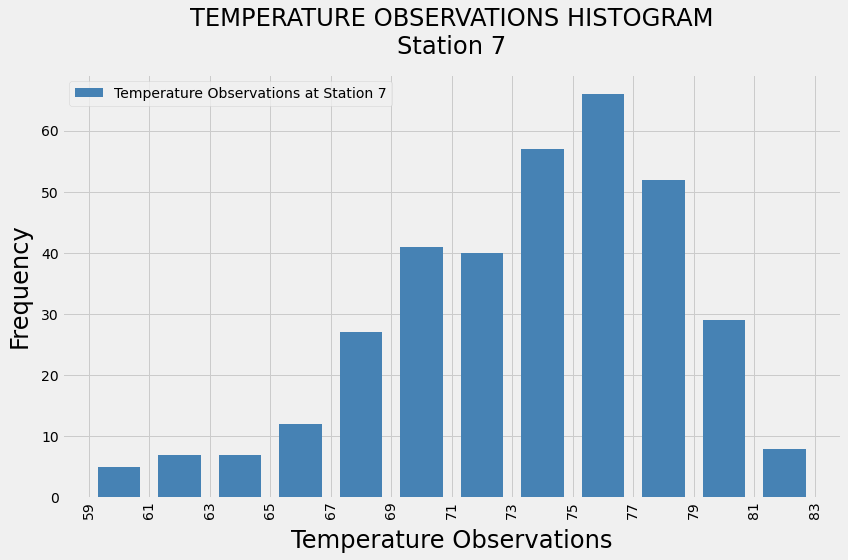

In [48]:
#Plot the temperature observations. 

temps = most_active_station_12months.iloc[:, 1]                                         # Set up x axis

plt.figure(figsize=(12, 8))                                           # Set up plot figure size

n, bins, patches = plt.hist(temps, bins=12, histtype='bar',        # Plot histogram with defined number of bins
                            align='mid', orientation='vertical', 
                            rwidth=.7,  color='steelblue', 
                            label=f"Temperature Observations at Station {most_active_station.id}")

plt.xticks(bins, rotation = 90)                                       # Set up x ticks

plt.xlabel('Temperature Observations', fontsize='xx-large', labelpad=10)  # Set up x axis label
plt.ylabel('Frequency', fontsize='xx-large', labelpad=10)             # Set up y axis label
plt.title(f"TEMPERATURE OBSERVATIONS HISTOGRAM\nStation {most_active_station.id}", fontsize='xx-large',             # Set up title
          loc='center', pad=20)

plt.legend()                                                          # Add legend

plt.tight_layout()

plt.savefig("output_charts/temp_obs_histogram.png", transparent=False)        # Export chart

plt.show()

# Close session

In [64]:
# Close Session
session.close()